

FILE: demo_imgs/hypersim/frame.0004.color.jpg

rotation by 90 degrees


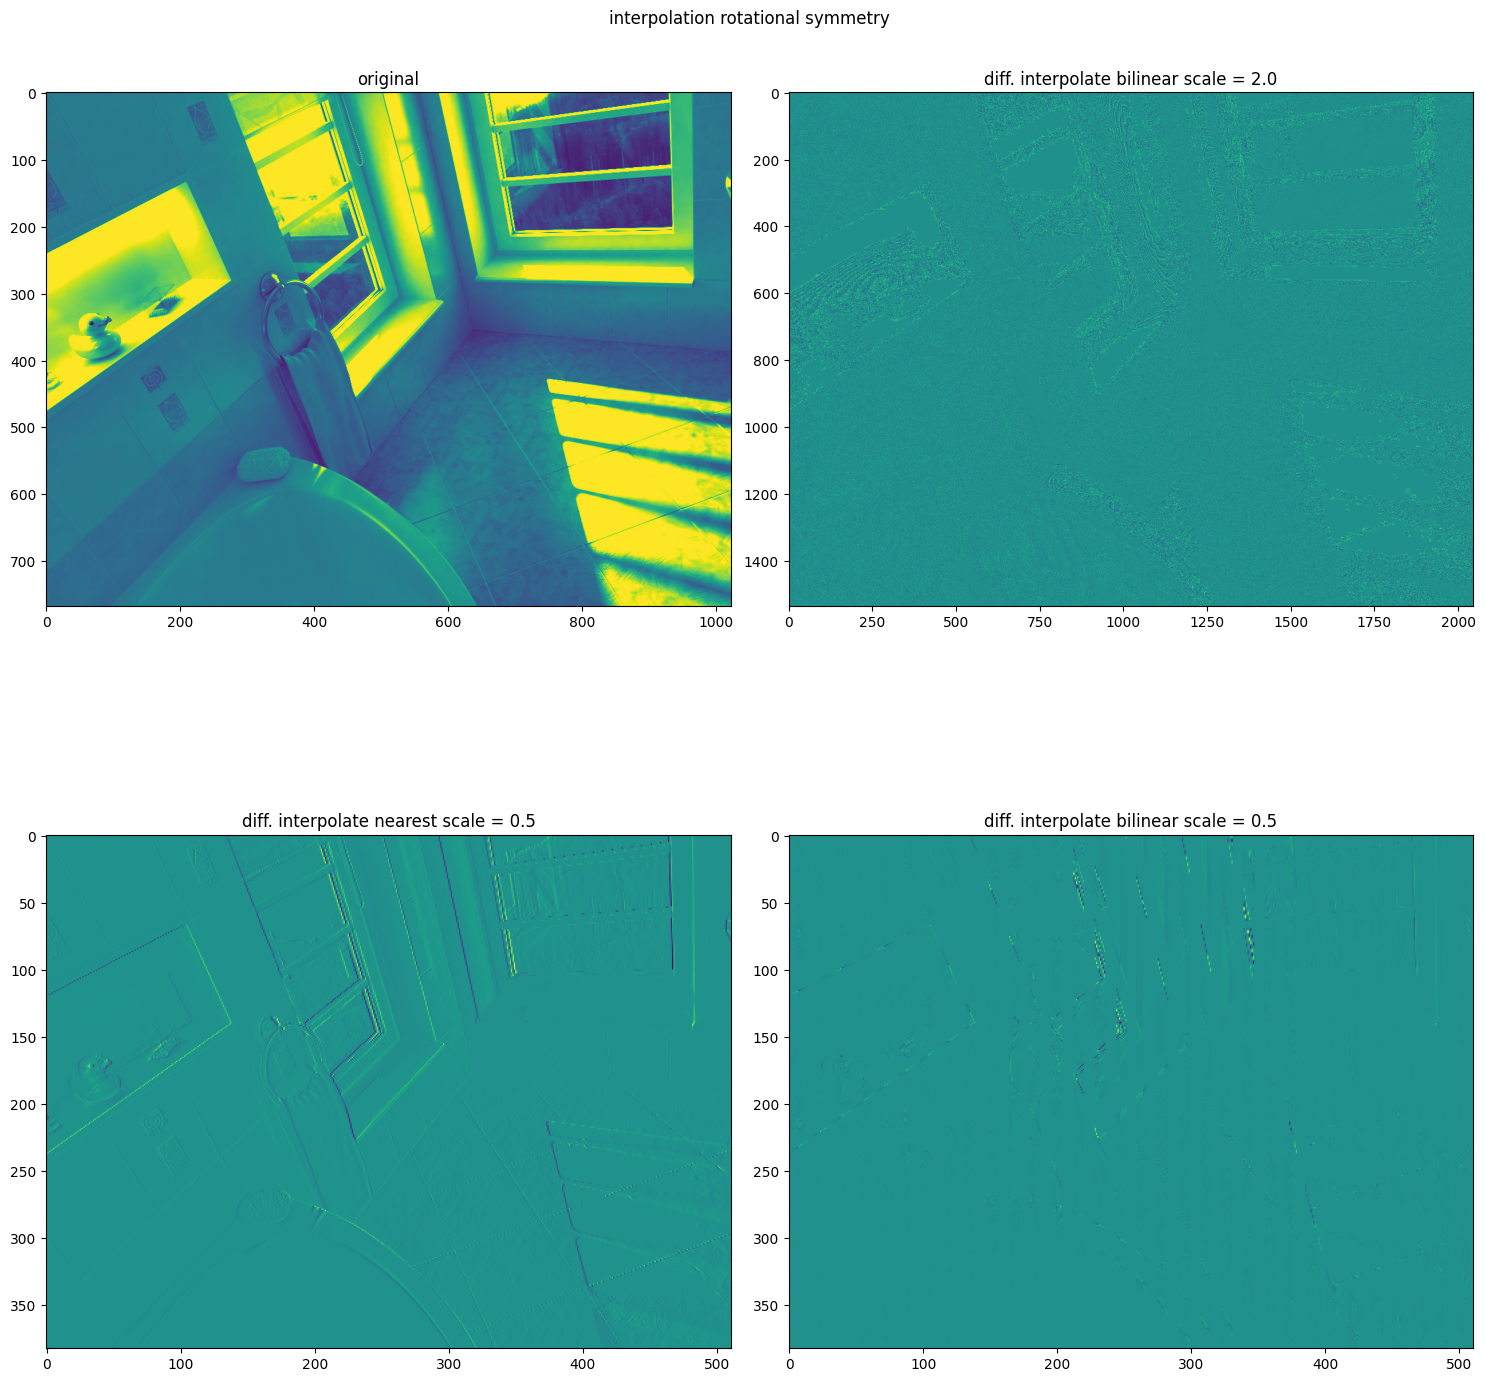

rotation by 180 degrees


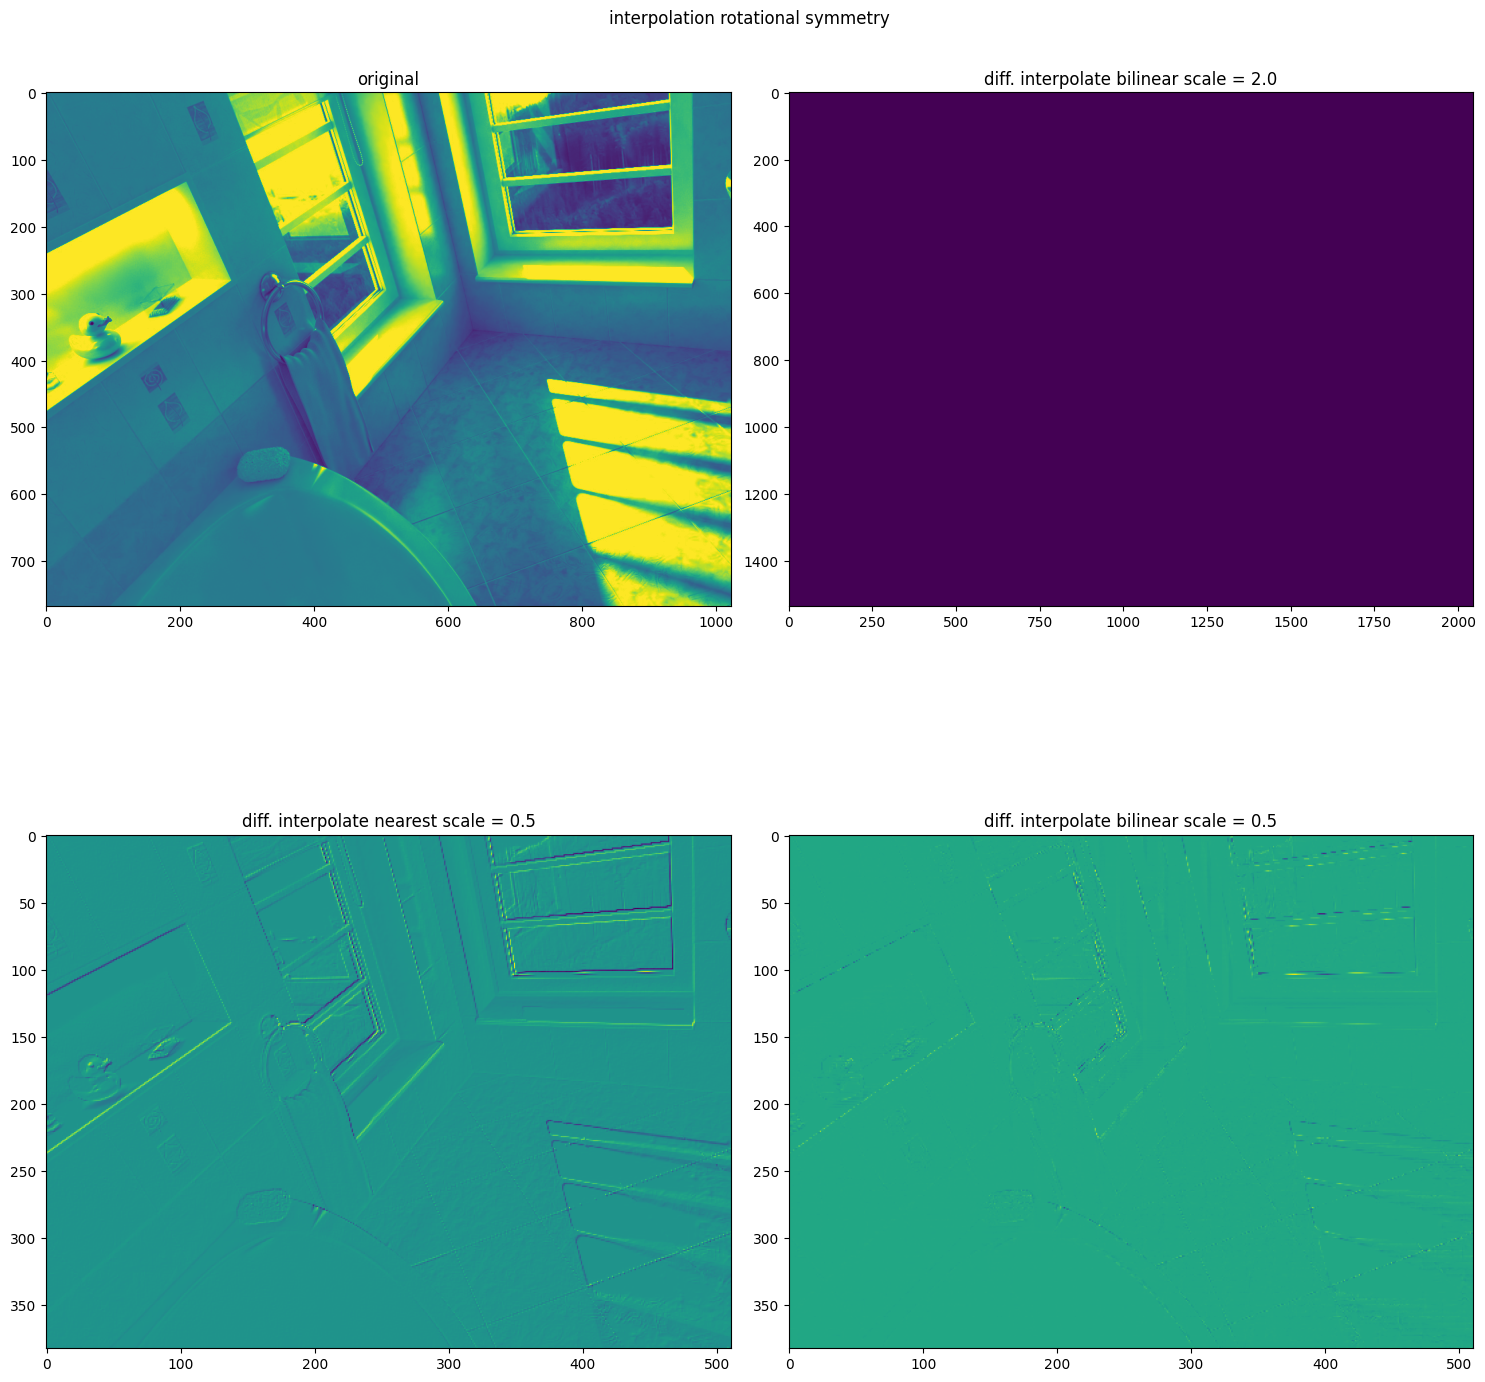

rotation by 270 degrees


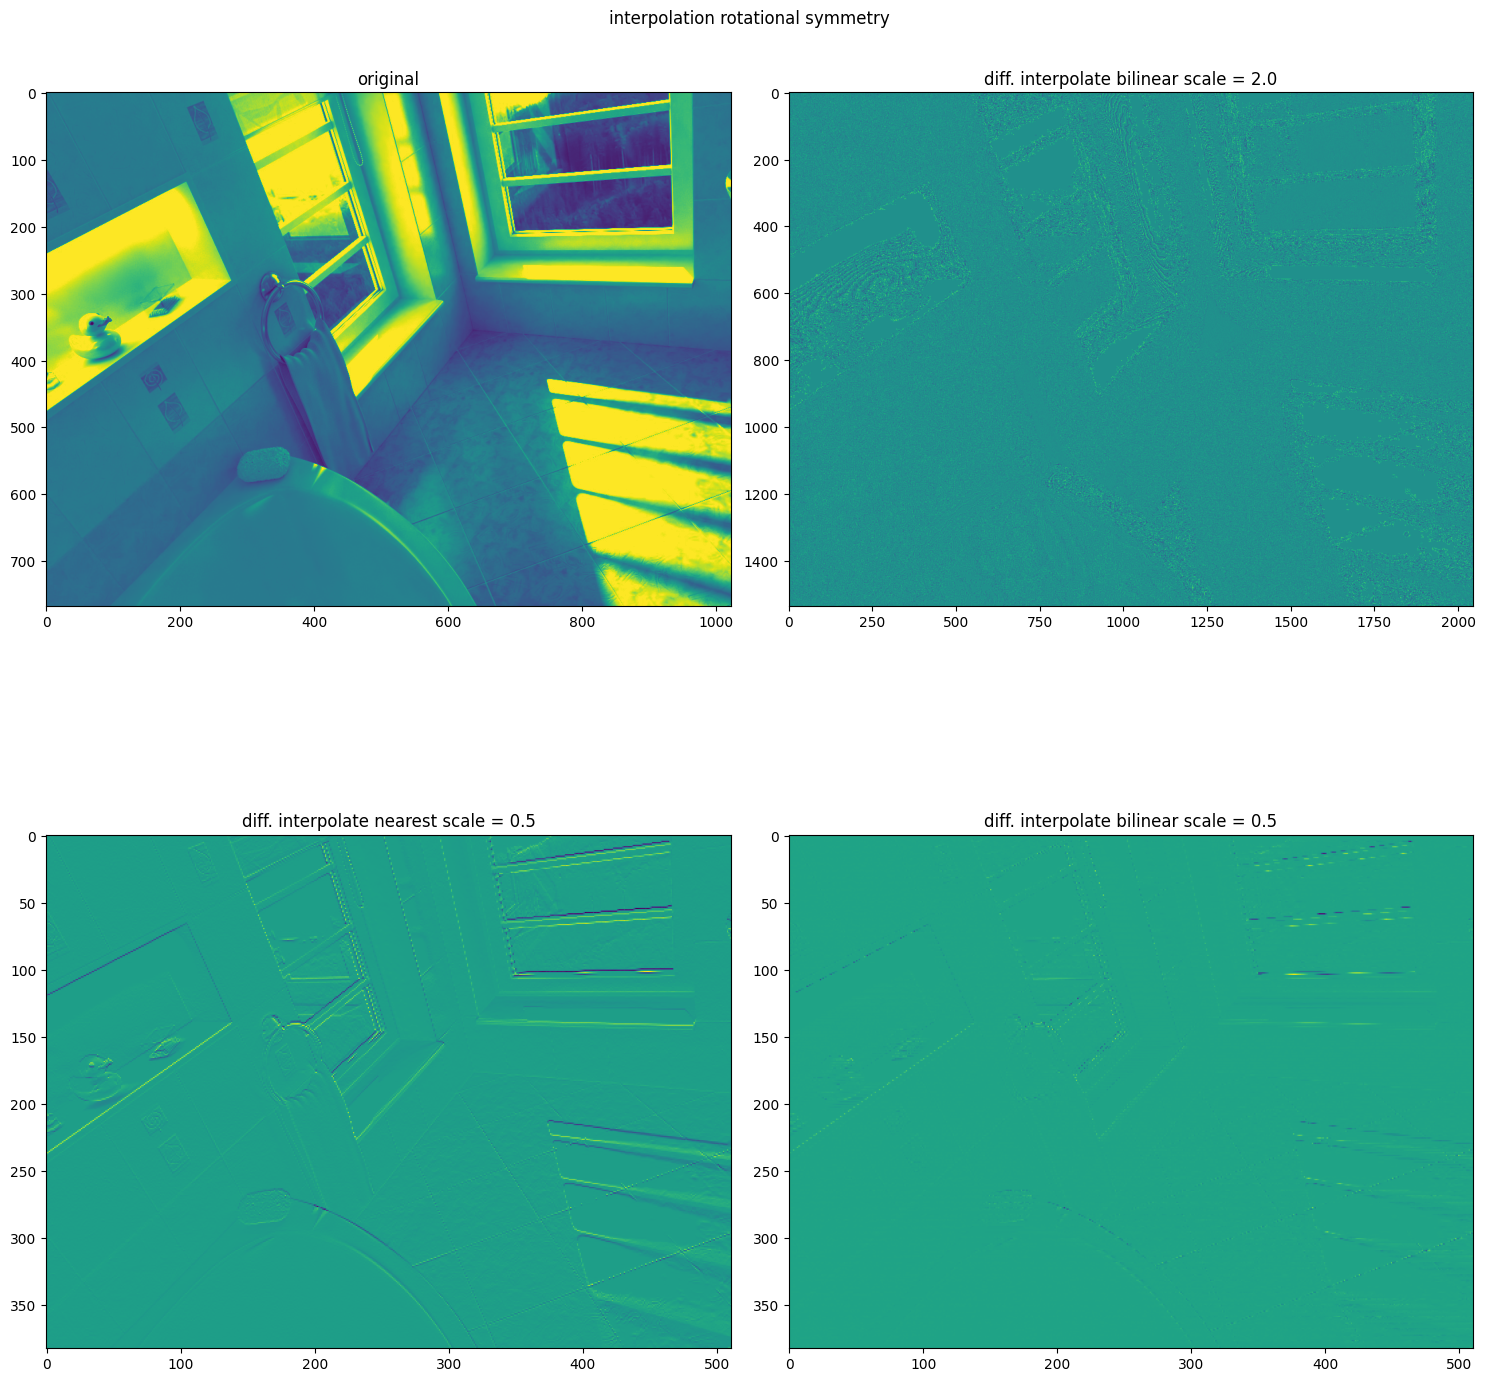

In [1]:
import os
import numpy as np
import torch

from PIL import Image

import torch.nn.functional as F

from kornia.filters import gaussian_blur2d
import kornia.utils as KU
import matplotlib.pyplot as plt


def prepare(title, rows=2, cols=2):

    fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
    fig.tight_layout()
    fig.suptitle(title)
    return axs


def add(axs, r, c, img, title):
    img = img[0, 0]
    axis = axs[r, c]
    axis.set_title(title)
    axis.imshow(img)


def get_kernel_size(sigma: float):
    ksize = int(2.0 * 4.0 * sigma + 1.0)

    if ksize % 2 == 0:
        ksize += 1
    return ksize


def kornia_gaussian_blur2d(x, sigma, separable=True):
    ksize = get_kernel_size(sigma)
    return gaussian_blur2d(x, (ksize, ksize), (sigma, sigma), separable=separable)


def rotate_experiment_gauss(file_path, rotations_90_deg):

    img_pil = Image.open(file_path)
    def modulo32(n):
        n_n = n - ((n + 1) % 32)
        assert n_n % 32 == 31
        return n_n
    crop = True
    if crop:
        w, h = img_pil.size[:2]
        w = modulo32(w)
        h = modulo32(h)
        img_pil = img_pil.crop((0, 0, w, h))
        # check_pil_mod(img_pil)
    img_np_o = np.array(img_pil)
    
    img_t_o = KU.image_to_tensor(img_np_o.copy(), False).float() / 255.
    img_t_r = torch.rot90(img_t_o, k=rotations_90_deg, dims=(2, 3))

    axs = prepare("interpolation rotational symmetry", rows=2, cols=2)
    add(axs, 0, 0, img_t_o, "original")

    img_t_o_int_2 = F.interpolate(img_t_o, scale_factor=2.0, mode='bilinear', align_corners=False)
    img_t_r_int_2 = F.interpolate(img_t_r, scale_factor=2.0, mode='bilinear', align_corners=False)
    img_t_b_int_2 = torch.rot90(img_t_r_int_2, k=4 - rotations_90_deg, dims=(2, 3))
    img_t_d_int_2 = img_t_o_int_2 - img_t_b_int_2
    add(axs, 0, 1, img_t_d_int_2, "diff. interpolate bilinear scale = 2.0")

    img_t_o_int_size_nearest = F.interpolate(img_t_o, size=(img_t_o.size(-2) // 2, img_t_o.size(-1) // 2), mode='nearest')
    img_t_r_int_size_nearest = F.interpolate(img_t_r, size=(img_t_r.size(-2) // 2, img_t_r.size(-1) // 2), mode='nearest')
    img_t_b_int_size_nearest = torch.rot90(img_t_r_int_size_nearest, k=4 - rotations_90_deg, dims=(2, 3))
    img_t_d_int_size_nearest = img_t_o_int_size_nearest - img_t_b_int_size_nearest
    add(axs, 1, 0, img_t_d_int_size_nearest, "diff. interpolate nearest scale = 0.5")

    img_t_o_int_size_bilinear = F.interpolate(img_t_o, size=(img_t_o.size(-2) // 2, img_t_o.size(-1) // 2), mode='bilinear')
    img_t_r_int_size_bilinear = F.interpolate(img_t_r, size=(img_t_r.size(-2) // 2, img_t_r.size(-1) // 2), mode='bilinear')
    img_t_b_int_size_bilinear = torch.rot90(img_t_r_int_size_bilinear, k=4 - rotations_90_deg, dims=(2, 3))
    img_t_d_int_size_bilinear = img_t_o_int_size_bilinear - img_t_b_int_size_bilinear
    add(axs, 1, 1, img_t_d_int_size_bilinear, "diff. interpolate bilinear scale = 0.5")

    plt.show()


def rotate_experiment_loop_gauss(img_to_show):

    img_dir = "demo_imgs/hypersim"
    files = ["{}/{}".format(img_dir, fn) for fn in os.listdir(img_dir)][:img_to_show]
    for file_path in files:
        print(f"\n\nFILE: {file_path}\n")
        for rots in range(1, 4):
            print(f"rotation by {rots * 90} degrees")
            rotate_experiment_gauss(file_path, rots)


rotate_experiment_loop_gauss(img_to_show=1)
